# Progetto 6: Jet Flavor Classification in High-Energy Physics with Deep Neural Networks

**Gruppo 45:**
 - Valli Arturo 1899846
 - Vizzaccaro Luca 1909876
 - Taggi Emilio 1910388

### Obiettivo:
classificare correttamente i jet adronici come originati da quark leggeri o da quark pesanti

**Step Intermedi:**
 - Lettura ed analisi del Dataset
 - Preprocessing delle feature
 - Implementazione e Training di diversi modelli
 - Valutazione e confronto delle prestazioni ottenute


**Dataset:** \\
 - Il dataset originale è reperibile a questo [link](https://mlphysics.ics.uci.edu/data/hb_jet_flavor_2016/), ed è il medesimo utilizzato in Guest, D., Collado, J., Baldi, P., et al.: Jet flavor classification in high-energy physics with deep neural networks. Physical Review D 94(11) (Dec 2016) [http://www.arxiv.org/abs/1607.08633 ](https://arxiv.org/abs/1607.08633)[hep-ex]; \\
 - Il dataset da noi utilizzato è reperibile al seguente [link](https://drive.google.com/file/d/1laqXoH8ywph0tdbzIc5-Ro9mTcvFdcHp/view?usp=sharing) ed è una modifica del dataset originale da noi implementata in python in cui sono state eliminate le variabili low level e medium level (che avrebbero reso il training del modello computazionalmente troppo oneroso) e le righe, ossia il numero di eventi, non sono stati cambiati in numero, ma sono state shufflate in modo da avere una distribuzione delle label più uniforme nel file     

# Import delle librerie, definizione di variabili e classi usate nel notebook

Cambiare proporzionalmente il numero di righe lette dal dataset e la batch_size a seconda di quanti dati si vogliono utilizzare:

In [ ]:
nrows = 1e5
batch_size = 512

Librerie utilizzate e variabili globali:


In [ ]:
#import librerie utilizzate
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split # per dividere il campione in train/validation/test
from sklearn.preprocessing import StandardScaler #per fare la normalizzazione delle feature
from imblearn.under_sampling import RandomUnderSampler #impotrto la funzione per fare underSampling

from sklearn.ensemble import RandomForestClassifier  #usato come modello di classificatore


from sklearn.metrics import confusion_matrix #per vedere la confusion matrix

import torch
import torchvision
from torch.utils.data import TensorDataset #per creare i Dataset torch
from torch.utils.data import DataLoader #per creare i DataLoader torch
torch.manual_seed(101)
from torch import nn #per creare reti neurali
import torch.nn.functional as F
from torchsummary import summary  #per il summary del modello
from sklearn import metrics #da qui prendo roc e auc score
from torch import optim #per ottimizzare i modelli
from torch.utils.data import Dataset #per la creazione del dataset custom nella RNN


import time #per contare il tempo che passa


random_state = 0 #random_state utilizzato in tutto il notebook

trainRatio = 0.8 # train set = 80% del dataset
valtestRatio = 0.5 #validation set = test set = 0.5 * (dataset - train set)


Liste relative alle feature del campione:

In [ ]:
#   lista dei nomi delle fetature di alto livello: 
#   variabili cinematiche - flavor - tack -vertex
 

trackNames = ['track_2_d0_significance', 'track_3_d0_significance', 'track_2_z0_significance', 
              'track_3_z0_significance', 'n_tracks_over_d0_threshold', 'jet_prob', 'jet_width_eta', 'jet_width_phi']

vertexNames = ['vertex_significance', 'n_secondary_vertices', 'n_secondary_vertex_tracks',
               'delta_r_vertex', 'vertex_mass', 'vertex_energy_fraction']

varNames = ['jet_pt','jet_eta', 'flavor'] + trackNames + vertexNames


#liste analoghe con i nomi da far apparire nei plot

trackNames_plot = [r'Track 2 $d_0$ significance', r'Track 3 $d_0$ significance', r'Track 2 $z_0$ significance',
                   r'Track 3 $z_0$ significance', r'Number of tracks over $d_0$ threshold', 'Jet probability',
                   r'Jet width $\eta$', r'Jet width $\phi$']

vertexNames_plot = ['Vertex significance', 'Number of secondary vertices', 'Number of tracks at secondary vertex',
                    r'Vertex $\Delta R$', 'Vertex mass', 'Vertex energy fraction']

varNames_plot = [r'Jet $p_t$',r'Jet $\eta$', 'Flavor'] + trackNames_plot + vertexNames_plot


#tolgo il flavor per ottenere una lista delle feature utilizzate del campione:

feat = varNames[:]
feat.remove('flavor') #feature del campione

feat_plot = varNames_plot[:]
feat_plot.remove('Flavor') #feature del campione da stampare su i plot

#unità di misura delle variabili da mettere su i grafici
feat_units = [' [GeV]','', '', '', '', '', '', '', '', '', '', '', '', '', '', ' [GeV]', '']

Classe per salvare il miglior modello durante il loop di Training:

In [ ]:
#Classe per salvare il best model incontrato nel loop di training
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf'),name='best_model.pt'): #inizializzo con best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        self.name = name
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
          
            torch.save({'model' : model,
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, self.name)

Definizione di accuracy da usare come metrica

In [ ]:
#definisco una funzione per calcolare l'accuracy
def accuracy(yhat, y):
    preds = torch.max(yhat,1)[1] #predizioni == neuroni con la massima probabilità
    batch_acc = (preds == y).sum()
    return batch_acc

Classe con la quale poter creare il dataset della RNN

In [ ]:
#Classe custom con cui si implementa il padding nella creazione del dataset per le sequenze di eventi

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features #features
        self.target = target #target
        self.sequence_length = sequence_length #lunghezza dela sequenza
        self.y = torch.tensor(dataframe[self.target].values,dtype=torch.long)
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    # il metodo __getitem__ implementa la logica del dataset
    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        outy = self.y[i] 
        return x, outy

# Download del Dataset

Per poter scaricare il dataset da noi modificato contenente solo le feature di alto livello vengono proposti due metodi implementati nelle due celle di codice successive (è sufficiente eseguirne solo una per poter procedere):
 1. eseguendo la cella colab il dataset modificato e da noi condiviso con un link google drive viene automaticamente scaricato
 2. si scarica manualmente al seguente [link](https://drive.google.com/file/d/1laqXoH8ywph0tdbzIc5-Ro9mTcvFdcHp/view?usp=sharing) il dataframe modificato da noi, lo si carica all'interno del proprio google drive e si inserisce nella cella colab il path al file appena scaricato, infine eseguendo la cella il dataset viene caricato all'interno del notebook

❕**Nota:** con entrambe i metodi dal notebook verrà richiesto l'accesso al proprio google drive personale     

In [ ]:
#@title 1. Download automatico

#Librerie necessarie per scaricare il dataset direttamente da colab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


#Autenticazione e creazione del PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


#id per scaricare il dataset
id = '1laqXoH8ywph0tdbzIc5-Ro9mTcvFdcHp'
#id ricavato dal link al dataset condiviso:
#https://drive.google.com/file/d/1laqXoH8ywph0tdbzIc5-Ro9mTcvFdcHp/view?usp=sharing


#nome del file
fileName = 'datasetHighLevel.json'


#download del dataset:
print("Download del dataset in corso, attendere...", end = '')
t0 = time.time()
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(fileName)
print("Download eseguito!")
print("Tempo impiegato: %.2f s" % (time.time()-t0) )



Download del dataset in corso, attendere...Download eseguito!
Tempo impiegato: 77.73 s


In [ ]:
#@title 2. Download manuale: inserire il path al dataset json sul proprio google drive

#per poter leggere i file dal mio drive in locale
from google.colab import drive
drive.mount('/content/drive')


#nome del path al file
fileName = '/content/drive/MyDrive/Colab Notebooks/datasetHighLevel.json' #@param {type: "string"}


Mounted at /content/drive


# Analisi del Dataset e Preprocessing delle Feature

Lettura del Dataset

In [ ]:
# creazione del pd dataframe dal file json:
df = pd.read_json(fileName, lines=True, nrows=nrows)

#  -fileName cambia a seconda di come si è scaricato il Dataset
#  -nrows è definito nella prima cella

## Printout iniziali e modifiche al dataset

In [ ]:
#rename delle colonne col giusto nome
df.columns = ['jet_pt', 'jet_eta', 'flavor', '{high level track variables}', '{high level vertex variables}']

#printout del dataset
display(df.head(5))

,jet_pt,jet_eta,flavor,{high level track variables},{high level vertex variables}
0,26.2247,0.112927,0,"[-inf, -inf, -inf, -inf, 0, 0.330291, 0.099247...","[-1, -1, -1, inf, -1, -inf]"
1,30.7206,1.642230,5,"[1.17387, 1.1105, 1.00325, 0.6081329999999999,...","[5.35272, 1, 3, 4.35992, 1.28849, 0.545407]"
2,26.5839,-0.553347,5,"[2.09755, 1.69441, 0.871352, 0.103666, 2, 0.00...","[5.6703, 1, 2, 0.206014, 0.339845, 0.47415]"
3,39.5845,-1.813510,0,"[0.059704, -inf, 0.651251, -inf, 0, 0.30442, 0...","[-1, -1, -1, inf, -1, -inf]"
4,26.8075,-0.574403,5,"[5.47629, 0.7581359999999999, 1.26116, 1.95222...","[42.9544, 1, 2, 0.32447899999999996, 0.758822,..."


In [ ]:
#spiattifico le liste con track e vertex nel df

df_temp = pd.DataFrame(df['{high level track variables}'].to_list(), columns=trackNames) #df con le track spiattificate
df = pd.concat([df, df_temp], axis = 1) #aggiungo al df le track spiattificate

df_temp = pd.DataFrame(df['{high level vertex variables}'].to_list(), columns=vertexNames) #df con le vertex spiattificate
df = pd.concat([df, df_temp], axis = 1) #aggiungo al df le vertex spiattificate

del df_temp #elimino il dataframe di appoggio

#elimino le colonne con track e vertex non spiattificate dal dataset
df = df.drop(['{high level track variables}'], axis = 1) #elimino la colonna tracks
df = df.drop(['{high level vertex variables}'], axis = 1) #elimino la colonna vertex

#printout del lavoro fatto
display(df.head(5))

,jet_pt,jet_eta,flavor,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction
0,26.2247,0.112927,0,-inf,-inf,-inf,-inf,0,0.330291,0.099247,0.241919,-1.00000,-1,-1,inf,-1.000000,-inf
1,30.7206,1.642230,5,1.17387,1.1105,1.00325,0.608133,1,0.002796,0.108153,0.110048,5.35272,1,3,4.35992,1.288490,0.545407
2,26.5839,-0.553347,5,2.09755,1.69441,0.871352,0.103666,2,0.000533,0.06443,0.118029,5.67030,1,2,0.206014,0.339845,0.47415
3,39.5845,-1.813510,0,0.059704,-inf,0.651251,-inf,0,0.304420,0.153046,0.079564,-1.00000,-1,-1,inf,-1.000000,-inf
4,26.8075,-0.574403,5,5.47629,0.758136,1.26116,1.95222,2,0.000087,0.033706,0.095034,42.95440,1,2,0.324479,0.758822,0.292777


In [ ]:
#converto le colonne da stringhe in numeri e rimpiazzo gli inf con -1

noData = -1 #valore utilizzato per dati mancanti

for i in trackNames + vertexNames : #ciclo sulle colonne con possibili valori mancanti
  df.loc[(df[i] == 'inf'), i] = noData #se compare inf lo metto a -1
  df.loc[(df[i] == '-inf'), i] = noData #se compare -inf lo metto a -1
  df.loc[(df[i] == '-NaN'), i] = noData #se compare -Nan lo metto a -1
  df[i] = pd.to_numeric(df[i]) #converto le colonne da str e float

#check sul lavoro fatto
display(df.head(5))

,jet_pt,jet_eta,flavor,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction
0,26.2247,0.112927,0,-1.000000,-1.000000,-1.000000,-1.000000,0,0.330291,0.099247,0.241919,-1.00000,-1,-1,-1.000000,-1.000000,-1.000000
1,30.7206,1.642230,5,1.173870,1.110500,1.003250,0.608133,1,0.002796,0.108153,0.110048,5.35272,1,3,4.359920,1.288490,0.545407
2,26.5839,-0.553347,5,2.097550,1.694410,0.871352,0.103666,2,0.000533,0.064430,0.118029,5.67030,1,2,0.206014,0.339845,0.474150
3,39.5845,-1.813510,0,0.059704,-1.000000,0.651251,-1.000000,0,0.304420,0.153046,0.079564,-1.00000,-1,-1,-1.000000,-1.000000,-1.000000
4,26.8075,-0.574403,5,5.476290,0.758136,1.261160,1.952220,2,0.000087,0.033706,0.095034,42.95440,1,2,0.324479,0.758822,0.292777


Possiamo ora guardare alla statistica descrittiva

In [ ]:
#printout statistica
display(df.describe())

,jet_pt,jet_eta,flavor,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,33.838535,-0.003535,2.439800,3.589149,1.677619,3.299863,1.656355,1.297230,0.037860,0.084122,0.093352,36.879060,-0.097710,0.921120,-0.456462,0.004258,-0.349280
std,12.567191,1.354553,2.401215,6.990746,4.455710,16.292977,8.805805,1.610475,0.104038,0.091416,0.093538,91.548237,1.252876,3.147621,0.937650,1.568802,0.889414
min,22.948600,-2.499740,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,26.279075,-1.129315,0.000000,0.547697,0.027555,0.328088,0.023360,0.000000,0.000031,0.055157,0.062700,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,30.080000,-0.012776,4.000000,1.146210,0.589454,0.857525,0.579391,1.000000,0.008212,0.083177,0.092530,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,36.802100,1.121160,5.000000,3.093703,1.433695,1.803175,1.383100,2.000000,0.052884,0.116678,0.127456,34.792925,1.000000,2.000000,0.080883,0.841686,0.519297
max,356.424000,2.499910,5.000000,149.124000,117.329000,867.027000,1073.240000,12.000000,0.414309,0.399856,0.398649,2434.030000,6.000000,38.000000,6.453530,16.540100,3.610980


In [ ]:
#printout correlazioni
display(df.corr())

,jet_pt,jet_eta,flavor,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction
jet_pt,1.000000,-0.006883,0.044184,0.116642,0.139971,0.026136,0.046499,0.144725,-0.057136,-0.053840,-0.060581,0.068207,0.107310,0.114028,0.074478,0.117861,0.074363
jet_eta,-0.006883,1.000000,0.000274,-0.004690,-0.000430,-0.007329,-0.001578,-0.002709,0.001398,-0.000724,-0.002335,0.000561,-0.001507,-0.000169,-0.003194,0.000773,-0.000989
flavor,0.044184,0.000274,1.000000,0.400920,0.376073,0.124419,0.167346,0.623492,-0.252874,0.116211,0.104909,0.380996,0.621528,0.557450,0.364475,0.578462,0.633725
track_2_d0_significance,0.116642,-0.004690,0.400920,1.000000,0.767127,0.395144,0.330386,0.658000,-0.174563,0.070440,0.098962,0.557232,0.496026,0.468755,0.246163,0.470237,0.473034
track_3_d0_significance,0.139971,-0.000430,0.376073,0.767127,1.000000,0.248060,0.377965,0.676555,-0.164746,0.070873,0.092167,0.554835,0.515967,0.522577,0.241805,0.510076,0.477417
track_2_z0_significance,0.026136,-0.007329,0.124419,0.395144,0.248060,1.000000,0.210956,0.219604,-0.059765,0.036263,0.026086,0.170900,0.118945,0.095822,0.059278,0.094371,0.111440
track_3_z0_significance,0.046499,-0.001578,0.167346,0.330386,0.377965,0.210956,1.000000,0.267576,-0.071339,0.046115,0.032502,0.242469,0.193646,0.168327,0.100042,0.166159,0.179961
n_tracks_over_d0_threshold,0.144725,-0.002709,0.623492,0.658000,0.676555,0.219604,0.267576,1.000000,-0.279443,0.103749,0.114163,0.557987,0.804588,0.819829,0.437531,0.800679,0.777587
jet_prob,-0.057136,0.001398,-0.252874,-0.174563,-0.164746,-0.059765,-0.071339,-0.279443,1.000000,0.574677,0.566345,-0.142906,-0.244270,-0.210924,-0.182133,-0.220468,-0.248379
jet_width_eta,-0.053840,-0.000724,0.116211,0.070440,0.070873,0.036263,0.046115,0.103749,0.574677,1.000000,0.797680,0.065839,0.103124,0.089654,0.080445,0.105120,0.101131


## Creazione Label e Analisi della loro Popolazione

La corrispondenza fra valore della variabile utilizzata come label e la classe di appartenzenza è la seguente:


Valore della variabile *flavor*  | Jet corrispondente  
---------------------------------|------------------------
0                                | Light Jet (Background)
4                                | Charm Jet (Background)
5                                | Bottom Jet (Signal)

\\

Valore della variabile *Label*   |  Categoria corrispondente  
---------------------------------|------------------------
0                                | Background (Light o Charm Jet)
1                                | Signal (Bottom Jet)



In [ ]:
#creo un array con le label
label = np.zeros(len(df))             #0 ovunque
label[np.where(df["flavor"]==5)] = 1  #tranne dove c'è un Bottom Jet

Flavor: [0, 5, 4] = ['Light Jet (Background)', 'Bottom Jet (Signal)', 'Charm Jet (Background)']
Occorrenze = [48801, 39184, 12015] 
Percentuali Popolazione = [0.48801 0.39184 0.12015]


Label: [0.0, 1.0] = ['Background', 'Signal']
Occorrenze = [60816, 39184] 
Percentuali Popolazione = [0.60816 0.39184]




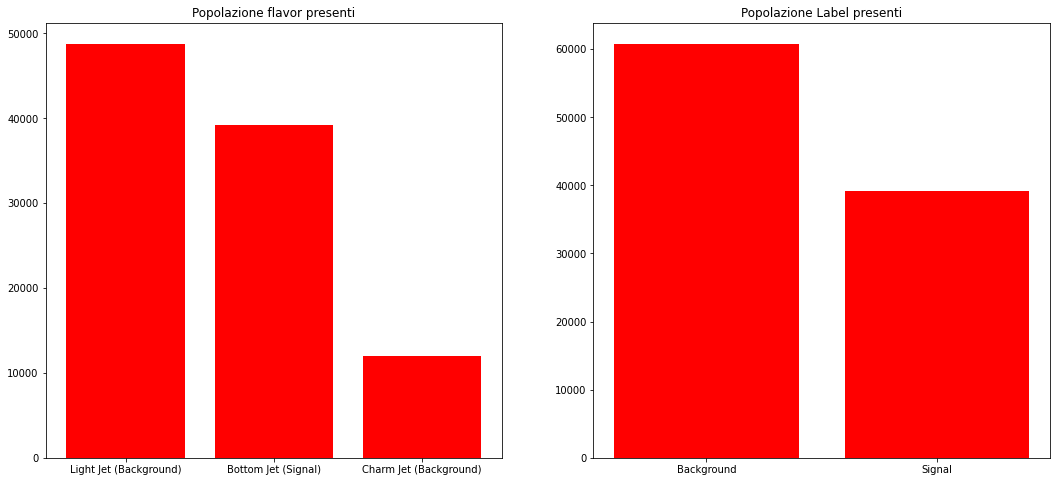

In [ ]:
#vediamo quali label sono presenti e se il dataset è sbilanciato

#funzione con cui conto il numero di occorennze per ogni label
from collections import Counter 


#per le variabili flavor:
flavor = df['flavor']    #mi prendo la colonna con i flavor 

flavDict = Counter(list(flavor)).items() #dizionario flavor:occorrenza per le flavor presenti

flavName = [i for i in Counter(list(flavor)).keys()]  #flavor presenti
flavOcc = [i for i in Counter(list(flavor)).values()] #occorennze per label

nameDict = {5:'Bottom Jet (Signal)',4: 'Charm Jet (Background)',0: 'Light Jet (Background)'} #mappo i numeri in stringhe 
flavName2 = [nameDict[i] for i in flavName] #lista flavor presenti (in formato stringa)

print(f"Flavor: {flavName} = {flavName2}")
print(f"Occorrenze = {flavOcc} \nPercentuali Popolazione = {flavOcc/np.sum(flavOcc)}\n\n")

#per le LABEL:

labDict = Counter(label).items() #dizionario flavor:occorrenza per le label presenti

labName = [i for i in Counter(label).keys()]  #label presenti
labOcc = [i for i in Counter(label).values()] #occorennze per label

labnameDict = {0:'Background',1:'Signal'}    #mappo i numeri in stringhe
labName2 = [labnameDict[i] for i in labName] #lista label presenti (in formato stringa)

print(f"Label: {labName} = {labName2}")
print(f"Occorrenze = {labOcc} \nPercentuali Popolazione = {labOcc/np.sum(labOcc)}\n\n")


#plot:

plt.figure(figsize=(18, 8))

#hist flavor
ax = plt.subplot(1,2,1) 
ax.bar(np.arange(len(flavName)),flavOcc,color='red')
ax.set_xticks([0,1,2])
ax.set_xticklabels(flavName2)
ax.set_title('Popolazione flavor presenti')

#hist label
ax = plt.subplot(1,2,2) 
ax.bar(np.arange(len(labName)),labOcc,color='red')
ax.set_xticks([0,1])
ax.set_xticklabels(labName2)
ax.set_title('Popolazione Label presenti')
plt.show()

Guardando all'istogramma delle Label il dataset risulta leggermente sbilanciato(60% vs 40%) per cui facciamo un under sampling del campione

In [ ]:
#faccio underSampling al dataset e all'array con le label
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=random_state)
df, label = undersampler.fit_resample(df, label)
print(f"Lunghezza del dataset dopo l'undersampling: {len(df)}")

Lunghezza del dataset dopo l'undersampling: 78368


Flavor: [0, 4, 5] = ['Light Jet (Background)', 'Charm Jet (Background)', 'Bottom Jet (Signal)']
Occorrenze = [31424, 7760, 39184] 
Percentuali Popolazione = [0.40097999 0.09902001 0.5       ]


Label: [0.0, 1.0] = ['Background', 'Signal']
Occorrenze = [39184, 39184] 
Percentuali Popolazione = [0.5 0.5]




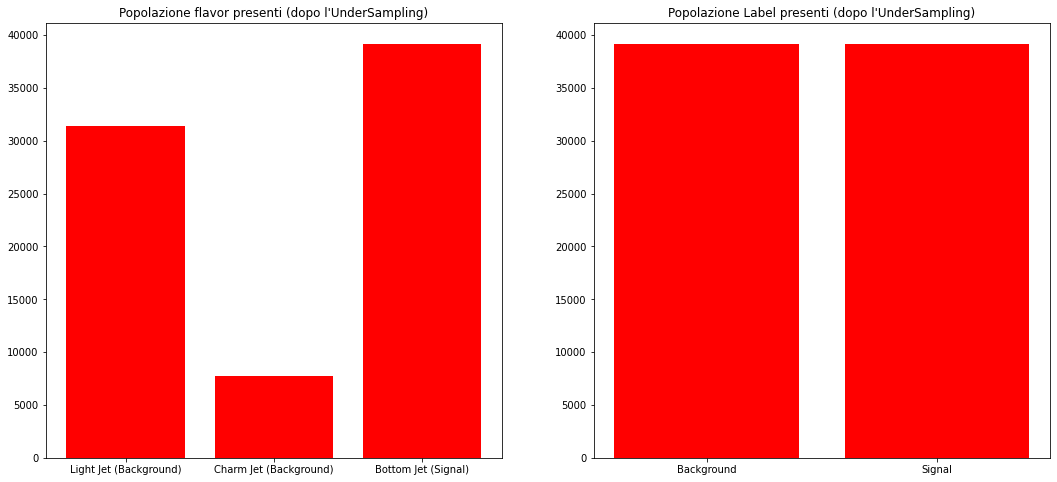

In [ ]:
#Grafico nuovamente le distribuzioni per vedere i risultati dell'UnderSampling

#per le variabili flavor:
flavor = df['flavor']    #mi prendo la colonna con i flavor 

flavDict = Counter(list(flavor)).items() #dizionario flavor:occorrenza per le flavor presenti

flavName = [i for i in Counter(list(flavor)).keys()]  #flavor presenti
flavOcc = [i for i in Counter(list(flavor)).values()] #occorennze per label

nameDict = {5:'Bottom Jet (Signal)',4: 'Charm Jet (Background)',0: 'Light Jet (Background)'} #mappo i numeri in stringhe 
flavName2 = [nameDict[i] for i in flavName] #lista flavor presenti (in formato stringa)

print(f"Flavor: {flavName} = {flavName2}")
print(f"Occorrenze = {flavOcc} \nPercentuali Popolazione = {flavOcc/np.sum(flavOcc)}\n\n")

#per le LABEL:

labDict = Counter(label).items() #dizionario flavor:occorrenza per le label presenti

labName = [i for i in Counter(label).keys()]  #label presenti
labOcc = [i for i in Counter(label).values()] #occorennze per label

labnameDict = {0:'Background',1:'Signal'}    #mappo i numeri in stringhe
labName2 = [labnameDict[i] for i in labName] #lista label presenti (in formato stringa)

print(f"Label: {labName} = {labName2}")
print(f"Occorrenze = {labOcc} \nPercentuali Popolazione = {labOcc/np.sum(labOcc)}\n\n")


#plot:

plt.figure(figsize=(18, 8))

#hist flavor
ax = plt.subplot(1,2,1) 
ax.bar(np.arange(len(flavName)),flavOcc,color='red')
ax.set_xticks([0,1,2])
ax.set_xticklabels(flavName2)
ax.set_title('Popolazione flavor presenti (dopo l\'UnderSampling)')

#hist label
ax = plt.subplot(1,2,2) 
ax.bar(np.arange(len(labName)),labOcc,color='red')
ax.set_xticks([0,1])
ax.set_xticklabels(labName2)
ax.set_title('Popolazione Label presenti (dopo l\'UnderSampling)')
plt.show()

## Rescaling e Preparazione del Dataset Torch


Per prima cosa dividiamo il dataset con le feature e l'array con le label nei dataset di train/validation/test (80%/10%/10%)

In [ ]:
#splitto dataset e label in 80% train 10% val 10% test
dataTr, dataSplit, labTr, labSplit = train_test_split(df[feat],label,
                                                      train_size = trainRatio, 
                                                      shuffle = True, 
                                                      random_state = random_state)
dataVal, dataTe, labVal, labTe = train_test_split(dataSplit,labSplit,
                                                  train_size = valtestRatio, 
                                                  shuffle = True, 
                                                  random_state = random_state)


#check sulle dimensioni
print(f"dataTr -> {dataTr.shape}")
print(f"labTr -> {labTr.shape}")
print(f"dataVal -> {dataVal.shape}")
print(f"labVal -> {labVal.shape}")
print(f"dataTe -> {dataTe.shape}")
print(f"labTe -> {labTe.shape}")

dataTr -> (62694, 16)
labTr -> (62694,)
dataVal -> (7837, 16)
labVal -> (7837,)
dataTe -> (7837, 16)
labTe -> (7837,)


Normalizziamo ora le feature (calcolando media e varianza solo sul train set)

In [ ]:
#normalizzazione delle feature:
normalizzatore = StandardScaler()  #chiamo il normalizzatore
normalizzatore.fit(dataTr) #normalizzazione calibrata sul train set

dataTrNorm = normalizzatore.transform(dataTr)#normalizzo il train set
dataValNorm = normalizzatore.transform(dataVal)#normalizzo anche il val e test set( con i paramentri del train)
dataTeNorm = normalizzatore.transform(dataTe)

In [ ]:
#check sulla normalizzazione:

#Train Set
print("Train Set")
print("Mean")
print(np.mean(dataTrNorm,axis=0))
print("Std")
print(np.std(dataTrNorm,axis=0))

#Validation Set
print("\nValidation Set")
print("Mean")
print(np.mean(dataValNorm,axis=0))
print("Std")
print(np.std(dataValNorm,axis=0))

#Test Set
print("\nTest Set")
print("Mean")
print(np.mean(dataTeNorm,axis=0))
print("Std")
print(np.std(dataTeNorm,axis=0))

Train Set
Mean
[-2.09669835e-16  2.08536484e-17 -5.30408014e-17  3.07137974e-17
 -1.67735868e-17  1.81336073e-17 -6.68676770e-18  2.72004110e-17
 -1.20361819e-16  1.36342060e-16 -6.31276205e-17 -7.12877438e-17
 -3.72872300e-17 -4.08006165e-18  4.76007192e-17 -9.06680366e-18]
Std
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Validation Set
Mean
[ 0.00518549 -0.01212082  0.01336418  0.00084329 -0.01518148 -0.00239372
  0.01254595 -0.00720946  0.00471503  0.00202978  0.00815128  0.02377947
  0.02154246  0.01087682  0.02577495  0.02265596]
Std
[0.99160921 0.9969186  1.03493544 0.95002839 0.70971854 0.69638415
 1.003658   0.99892722 1.00433394 0.99958465 0.95636989 1.00824306
 1.00615823 1.00466519 1.01592652 1.00667845]

Test Set
Mean
[ 0.01330364 -0.00358503  0.02162095  0.00929863 -0.0016264  -0.00715605
  0.01877226  0.00747478  0.00875369  0.00723702  0.02089435  0.02650707
  0.02562745  0.00828957  0.02572959  0.01958567]
Std
[1.07994041 0.98751673 1.06053708 1.00602945 0.9044046

Vengono ora preparati i dataset in formato torch

In [ ]:
#conversione in tensori torch:

#x = tensore con le feature di input
xTr = torch.FloatTensor(dataTrNorm)
xVal = torch.FloatTensor(dataValNorm)
xTe = torch.FloatTensor(dataTeNorm)

#y = tensore con le label di riferimento
yTr = torch.LongTensor(labTr)
yVal = torch.LongTensor(labVal)
yTe = torch.LongTensor(labTe)

#check sulla shape dei tensori 
print("check dimensionalità:")
print(f"xTr shape {xTr.shape}")
print(f"yTr shape {yTr.shape}\n")
print(f"xVal shape {xVal.shape}")
print(f"yVal shape {yVal.shape}\n")
print(f"xTe shape {xTe.shape}")
print(f"yTe shape {yTe.shape}")

check dimensionalità:
xTr shape torch.Size([62694, 16])
yTr shape torch.Size([62694])

xVal shape torch.Size([7837, 16])
yVal shape torch.Size([7837])

xTe shape torch.Size([7837, 16])
yTe shape torch.Size([7837])


In [ ]:
#creazione dataset torch
trainDataset = TensorDataset(xTr,yTr)
valDataset = TensorDataset(xVal,yVal)
testDataset = TensorDataset(xTe,yTe)

#creazione dei DataLoader

#batch_size = 256 #->definita a inizio file

trainLoader = DataLoader(
    trainDataset,
    batch_size=batch_size, #batch size definita nella prima cella
    shuffle=True,
    drop_last=True         #perché in generale nrows % batch_size != 0
)

valLoader = DataLoader(
    valDataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

testLoader = DataLoader(
    testDataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)


#prova del dataloader
x, y = next(iter(trainLoader))
print("Prova del DataLoader")
print("Features shape:", x.shape)
print("Target shape:", y.shape)
print(f"x:\n{x}")
print(f"y:\n{y}")

Prova del DataLoader
Features shape: torch.Size([512, 16])
Target shape: torch.Size([512])
x:
tensor([[-0.3304,  0.6839,  0.1283,  ...,  0.5518,  1.6895,  1.3705],
        [-0.8152,  1.1299,  1.0855,  ...,  0.4671,  2.0629,  1.5652],
        [ 0.7352,  0.3620, -0.4756,  ..., -0.6641, -0.7235, -0.8357],
        ...,
        [-0.7321, -1.5420, -0.5063,  ..., -0.6641, -0.7235, -0.8357],
        [-0.0832,  1.5211, -0.3542,  ...,  0.5760,  1.3134,  0.8625],
        [ 2.1120,  0.0668, -0.4405,  ..., -0.6641, -0.7235, -0.8357]])
y:
tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0

## Analisi delle Feature

Guardiamo per prima cosa alla dristribuzione delle diverse variabili

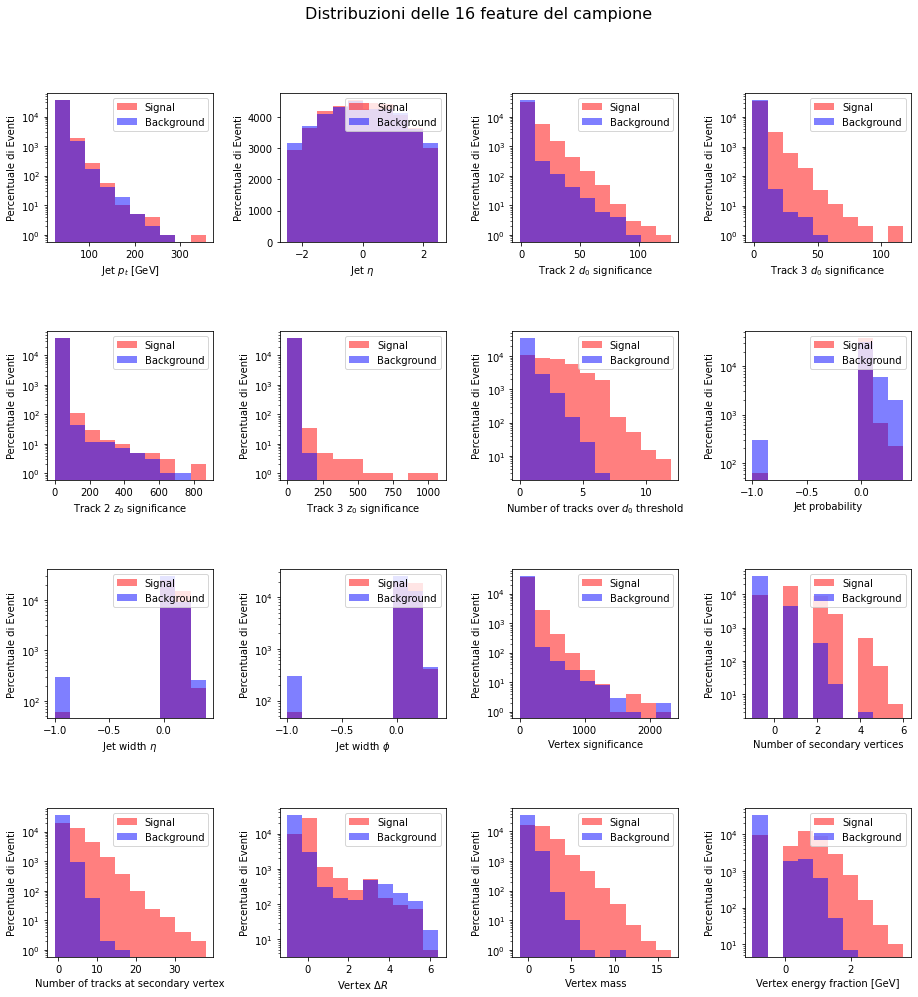

In [ ]:
plt.figure(figsize=(15,15))


for i,f in enumerate(feat):
  sp=plt.subplot(4,4,i+1)
  hist,bin,_ = plt.hist(df[f][label == 1],color='red',edgecolor='None',histtype='stepfilled',rwidth=0.9,alpha=0.5,density=False, label = "Signal")
  _ = plt.hist(df[f][label == 0],color='blue',edgecolor='None',histtype='stepfilled',rwidth=0.9,alpha=0.5,density=False,bins = bin, label = "Background")
  
  plt.xlabel(feat_plot[i]+feat_units[i])
  plt.ylabel('Percentuale di Eventi')
  if i!=1:  # per tutte le feature tranne la seconda uso una scala logaritmica 
    plt.yscale('log')
  plt.legend()


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)

plt.suptitle('Distribuzioni delle 16 feature del campione', fontsize=16)
plt.show()

Ordiniamo ora le variabili per importanza facendo uso di un RandomForestClassifier

In [ ]:
#uso un classificatore RandomForest per ottenre il ranking delle varibili per importanza:

modelloForest = RandomForestClassifier(n_estimators=100,min_samples_split=100,random_state=random_state) #instanzio una RandomForest

modelloForest.fit(dataTrNorm,labTr) #fitto il modello (al solo TrainSet per non avere leak di informazioni)

importances = modelloForest.feature_importances_ #ottengo la lista dell'importanza delle feature

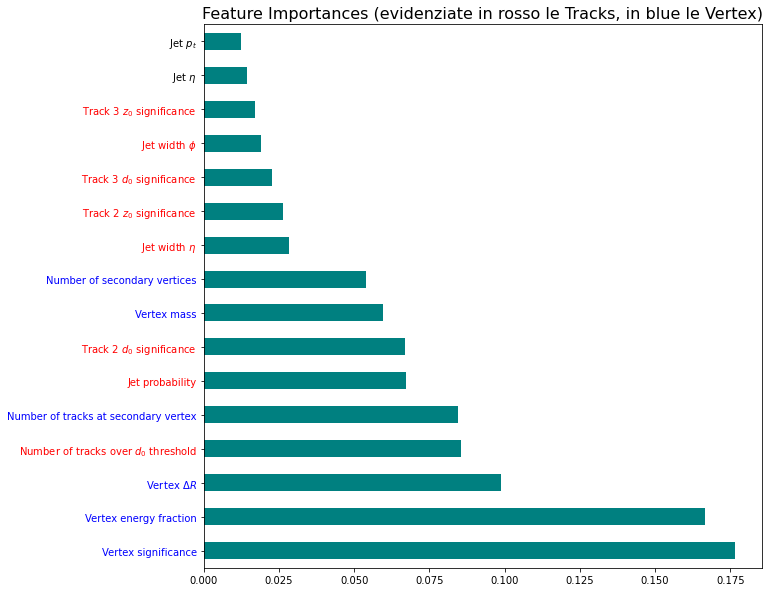

In [ ]:
#ordino la lista per poterci fare un plot:

orderedIndex = np.argsort(importances)[::-1] #indici dal maggiore al minore 
orderedColumns = [ feat_plot[ orderedIndex[i] ] for i in range(len(feat_plot)) ] #nomi delle colonne ordinate
orderedImportances = [ importances[ orderedIndex[i] ] for i in range(len(importances)) ]

myColors = ['black','black'] +  ['red'] * len(trackNames) + ['blue'] * len(vertexNames) #colori che voglio sul grafico
orderedColors = [ myColors[ orderedIndex[i] ] for i in range(len(myColors)) ]

#plot:

plt.figure(figsize=(10,10))
feat_importances = pd.Series(orderedImportances,orderedColumns)
feat_importances.plot(kind='barh',color='teal')

#coloro in rosso le track feature e in blue le vertex feature
for i in range(len(feat)):
  plt.gca().get_yticklabels()[i].set_color(orderedColors[i])

plt.title("Feature Importances (evidenziate in rosso le Tracks, in blue le Vertex)", fontsize=16)

plt.show()

In [ ]:
#Guardo quali sono le 5 feature più significative:
Nfeat = 5  #solo 5 feature

print(f"Prime {Nfeat} feature più significative con relativa importanza")

for i,f in enumerate(orderedColumns[:Nfeat] ):
  print(f"{i+1}) {f} -> {orderedImportances[i]}")

Prime 5 feature più significative con relativa importanza
1) Vertex significance -> 0.17660869912204138
2) Vertex energy fraction -> 0.1665960743855968
3) Vertex $\Delta R$ -> 0.0988788535498718
4) Number of tracks over $d_0$ threshold -> 0.08552581380818944
5) Number of tracks at secondary vertex -> 0.08438793710286621


Il ranking delle variabili per importanza verrà rieseguito in seguito dopo aver ottimizzato gli iper-parametri della Random Forest

Guardiamo ora alla correlazione fra le variabili:

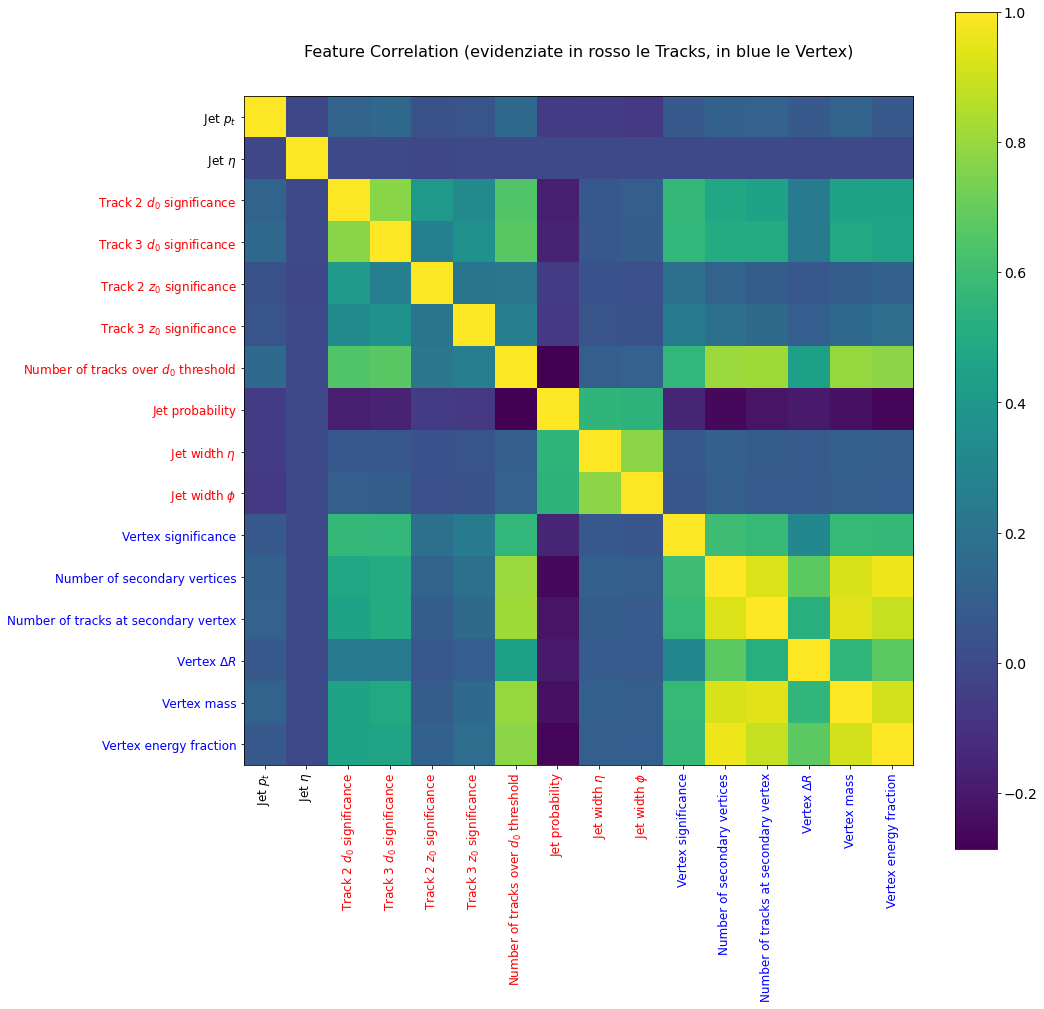

In [ ]:
# plot correlazioni tra i sensori

plt.figure(figsize=(15,15))

plt.matshow(df[feat].corr(),fignum=1)
plt.xticks(range(df[feat].shape[1]), feat_plot, fontsize=12, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(df[feat].shape[1]), feat_plot, fontsize=12)

#coloro in rosso le track feature
for i in range(len(trackNames)):
  plt.gca().get_xticklabels()[2+i].set_color("red")
  plt.gca().get_yticklabels()[2+i].set_color("red")

#coloro in blue le vertex feature
for i in range(len(vertexNames)):
  plt.gca().get_xticklabels()[2+len(trackNames)+i].set_color("blue")
  plt.gca().get_yticklabels()[2+len(trackNames)+i].set_color("blue")



cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation (evidenziate in rosso le Tracks, in blue le Vertex)", fontsize=16)
plt.show()


È possibile notare che le feature Vertex di alto livello appaiono fortemente correlate, ciò è atteso in quanto se non si è in grado di ricostruire un vertice nessuna delle Vertex feature è presente: sapendo che una manca è noto anche che mancano tutte le altre 

## Salvataggio dataframe

In [ ]:
newFileName = 'dataset_preprocessed.pkl' #lo salvo su file
df.to_pickle(newFileName)
del df #lo elimino

# Training di diversi modelli sul Dataset creato

Se disponibile ci spostiamo subito sulla GPU:

In [ ]:
# controlliamo che la GPU sia disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(0))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu'
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



Proponiamo ora 3 modelli di cui si è fatto uso:

## 1) Rete neurale densa

La batch size qui utilizzata è la stessa definita all'inizio del notebok.

Modificare la seguente cella per un diverso numero di epoche nel loop di training:

In [ ]:
epochs = 150 #numero di epoche per cui si farà il training

### Definizione del modello

In [ ]:
#implemento ora un classificatore con una rete neurale densa:

inDim = len(feat) #dimensione di ingresso = numero di feature

#rete densa:
class myDenseMLP(nn.Module):
  def __init__(self, input_dim=inDim, output_dim=2, hidden_dims=128, pDrop = 0.15):
    super(myDenseMLP, self).__init__()
    
    self.layer1 = nn.Linear(input_dim, hidden_dims)  #hidden layer
    self.drop1 = nn.Dropout(p=pDrop) #droput1

    self.layer2 = nn.Linear(hidden_dims, hidden_dims) #hidden layer 2
    self.drop2 = nn.Dropout(p=pDrop) #droput2

    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.drop3 = nn.Dropout(p=pDrop) #droput3

    self.layer4 = nn.Linear(hidden_dims, hidden_dims) #hidden layer 3
    self.drop4 = nn.Dropout(p=pDrop) #droput4

    self.layer5 = nn.Linear(hidden_dims, hidden_dims*2) #hidden layer 3
    self.drop5 = nn.Dropout(p=pDrop*2) #droput5

    self.layer6 = nn.Linear(hidden_dims*2, hidden_dims*2)
    self.layer7 = nn.Linear(hidden_dims*2,output_dim)

    
  def forward(self, x):
    x = self.drop1( F.relu( self.layer1(x) ) ) #5 layer con Relu e Dropout
    x = self.drop2( F.relu( self.layer2(x) ) )
    x = self.drop3( F.relu( self.layer3(x) ) )
    x = self.drop4( F.relu( self.layer4(x) ) )
    x = self.drop5( F.relu( self.layer5(x) ) )

    x = F.relu( self.layer6(x) ) #1 layer con Relu senza Droput

    x = self.layer7(x) #1 layer senza Relu ne Dropout

    out = F.log_softmax(x, dim=1) #in uscita usiamo softmax essendo una classificazione

    return out

In [ ]:
#istanzio il modello

modello1 = myDenseMLP(input_dim=inDim, output_dim=2, hidden_dims=128, pDrop = 0.15)

#guardo al Summary del Modello

print("Summary del Modello:\n")

if torch.cuda.is_available():
  summary(modello1.cuda(), input_size=(1,inDim))
else:
  summary(modello1, input_size=(1,inDim))


#testo il modello su un batch

x, y = next(iter(trainLoader))

x=x.to(device)
y=y.to(device)

out = modello1(x.view(batch_size,-1))
print(f"\nTest su un batch:\n{out}")

Summary del Modello:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           2,176
           Dropout-2               [-1, 1, 128]               0
            Linear-3               [-1, 1, 128]          16,512
           Dropout-4               [-1, 1, 128]               0
            Linear-5               [-1, 1, 128]          16,512
           Dropout-6               [-1, 1, 128]               0
            Linear-7               [-1, 1, 128]          16,512
           Dropout-8               [-1, 1, 128]               0
            Linear-9               [-1, 1, 256]          33,024
          Dropout-10               [-1, 1, 256]               0
           Linear-11               [-1, 1, 256]          65,792
           Linear-12                 [-1, 1, 2]             514
Total params: 151,042
Trainable params: 151,042
Non-trainable params: 0
---------

In [ ]:
# loss function 
loss_func = nn.CrossEntropyLoss() #usiamo questa per la task di classificazione

#metrica usata
metric_func = accuracy

# ottmizzatore:
opt1 = optim.Adam(modello1.parameters(), lr=0.001) #Adam come ottimizzatore
scheduler1 = optim.lr_scheduler.StepLR(opt1, 50, gamma=0.1, last_epoch=-1, verbose=True) #diminuisco il lr ogni 50 epoche

Adjusting learning rate of group 0 to 1.0000e-03.


### Ciclo di Training e risultati

In [ ]:
#Training loop

modello1.to(device)   #sposto il modello sul device in uso
save_best_model1 = SaveBestModel(name='bestDenseMLP.pt') #-> inizializzo la funzione per salvarmi il bestModel

# numero di epoche definito nella prima cella della Rete Neurale densa


# liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione 
# dell'epoca a fine addestramento
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

# loop sulle epoche
for epoch in range(epochs):
    t0 = time.time()
    
    # training step (in cui aggiorniamo i pesi della rete neurale)
    modello1.train()
    train_loss = 0
    train_metric = 0
    counter = 0

    for xb, yb in trainLoader:
        counter += 1
        xb=xb.to(device) #copio il mini batch di dati sulla CPU/GPU
        yb=yb.to(device) #copio il mini batch di label sulla CPU/GPU

        pred = modello1(xb) #predizione del modello

        # calcolo loss e metrica
        loss = loss_func(pred.squeeze(), yb)
        metric = metric_func(pred.squeeze(), yb)

        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        train_metric += metric.item()

        # backpropagation
        opt1.zero_grad() #resetta i gradienti prima di eseguire la backpropagation
        loss.backward() #calcola i gradeinti della loss
        opt1.step() #aggiorna i pesi


    train_loss /= counter
    train_metric /= (counter*batch_size)
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # validation step (non vengono aggiornati i pesi)
    modello1.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad(): #evita che si aggiornino i pesi
      for xb, yb in valLoader:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = modello1(xb) #predizione del modello

        # calcolo loss e metrica
        vloss = loss_func(pred.squeeze(), yb)
        vmetric = metric_func(pred.squeeze(), yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()  

    vali_loss /= counter
    vali_metric /= (counter*batch_size)
    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model1(vali_loss, epoch, modello1, opt1, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train Accuracy: %.6f, vali loss: %.6f, vali Accuracy: %.6f" 
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))
    
    # update learning rate schedule
    scheduler1.step()


Best validation loss: 0.37735631863276164

Saving best model for epoch: 1

epoch: 1, time(s): 0.8004, train loss: 0.420999, train Accuracy: 0.822922, vali loss: 0.377356, vali Accuracy: 0.834766
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 0.3746451993783315

Saving best model for epoch: 2

epoch: 2, time(s): 0.7563, train loss: 0.381472, train Accuracy: 0.836466, vali loss: 0.374645, vali Accuracy: 0.832161
Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 3, time(s): 0.8841, train loss: 0.377088, train Accuracy: 0.837683, vali loss: 0.380280, vali Accuracy: 0.833984
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 0.3677915374437968

Saving best model for epoch: 4

epoch: 4, time(s): 0.7669, train loss: 0.375074, train Accuracy: 0.837923, vali loss: 0.367792, vali Accuracy: 0.839193
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 0.36558568676312764

Saving best model for epoch: 5

epoch: 5, time(s):

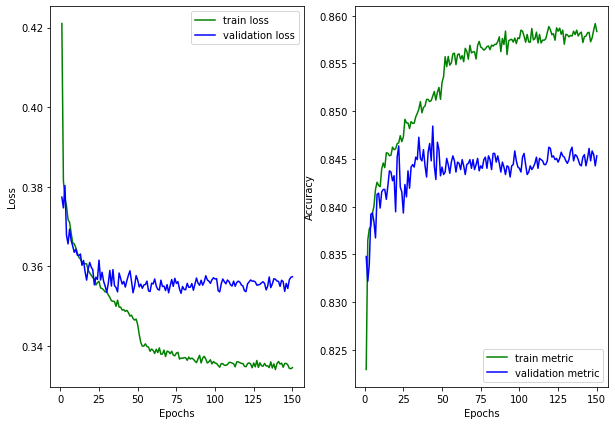

In [ ]:
# grafico monitoring training
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Guardo l'accuracy sul test set:

In [ ]:
# test set performance

# lettura del modello
model_data = torch.load('./bestDenseMLP.pt')  #il best model è quello che ha dato la migliore prestazione
print('Best model at epoch: ', model_data['epoch']) #nel dizionario era salavata anche l'epoca in cui è stato raggiunto il best
model = model_data['model'] 
model.eval() #va sempre fatto per settare eventuali layer di droput e batch norm in evaluation model


loss = 0
metric = 0
counter = 0

for xb, yb in testLoader:
  counter += 1
  xb=xb.to(device)
  yb=yb.to(device)
  pred = model(xb)

  loss += loss_func(pred, yb).item()
  metric += metric_func(pred, yb).item()


loss /= counter
metric /= (counter*batch_size)

print('Test loss/accuracy: ',loss, ' / ', metric)

accDense = metric #salvo l'accuracy per ristamparla in seguito

Best model at epoch:  78
Test loss/accuracy:  0.35023511449495953  /  0.8545572916666667


Matrice di correlazione:

In [ ]:
#mi stampo la confusion matrix

model.to(torch.device('cpu')) #mi sposto sulla cpu

predictions = np.empty(shape=(0,))
truths = np.empty(shape=(0,))
 
for xb, yb in testLoader:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb)

  res = torch.argmax(pred, dim=1)

  predictions = np.concatenate((predictions,res.detach().numpy()))
  truths = np.concatenate((truths,yb.detach().numpy()))

c_mat = confusion_matrix(predictions, truths, normalize='true')
print('Matrice di correlazione: ')
print(c_mat)

del predictions #per pulire la memoria
del truths

Matrice di correlazione: 
[[0.8346221  0.1653779 ]
 [0.12367202 0.87632798]]


Calcolo dell'Auc relativa alla Roc:

In [ ]:
auc = []
for xb, yb in testLoader:
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  outputs = model(xb.view(batch_size,-1))
  pred = torch.argmax(outputs.data,1)

  fpr, tpr, thresholds = metrics.roc_curve(yb.detach().numpy(), pred)
  auc.append(metrics.auc(fpr, tpr))

print(f"AUC = {round(np.mean(auc),4)} +- {round(np.std(auc),4)}")

aucDense = np.mean(auc) #salvo l'auc per ristamparla in seguito

AUC = 0.8547 +- 0.0148


## 2) Random Forest Classifier

Iniziamo facendo una prima grid search per ottimizzare gli iper-parametri della RandomForest

In [ ]:
 #per disabilitare gli warnings
import warnings
warnings.filterwarnings("ignore")

#Range di iperparametri che testo
nEst_range = np.linspace(2,200,10, dtype='int') #n_estimator
leafSize_range = np.array([10,100,1000]) #leaf_size

Nnest = len(nEst_range)
Nleaf = len(leafSize_range)

#liste in cui conservare le accuracy
accOOBList = np.zeros((Nleaf,Nnest))
accTrList = np.zeros((Nleaf,Nnest))
accValList = np.zeros((Nleaf,Nnest))

bestScore = 0 #mi segno i valori migliori che otterrò dai vari modelli
bestLeafSize = nEst_range[0]
bestNest = leafSize_range[0]

print("(leaf_size,n_estimator)      accuracyTrainSet        accuracyValSet       accuracyOOB ")

#Grid Search:
for i,leaf_size in enumerate(leafSize_range): #ciclo sulla dimensione delle foglie
  #setup del randomforest
  clfRF = RandomForestClassifier(
        n_estimators=nEst_range[0],
        max_depth=None, 
        min_samples_split=leaf_size, 
        oob_score=True,
        random_state=random_state,
        warm_start=True 
    )
  
  for j,n_est in enumerate(nEst_range):

    clfRF.set_params(n_estimators=n_est) #setup random forest

    clfRF.fit(dataTrNorm,labTr) #alleno la random forest

    #calcolo le accuracy
    accTr = clfRF.score(dataTrNorm,labTr)
    accVal = clfRF.score(dataValNorm,labVal)
    accOOB = clfRF.oob_score_

    accTrList[i,j] = accTr
    accValList[i,j] = accVal
    accOOBList[i,j] = accOOB

    print(f"({leaf_size,n_est})                    {np.round(accTr,5)}                 {np.round(accVal,5)}                 {np.round(accOOB,5)}")

    if bestScore <= accOOB : #se l'accuracy aumenta segno il best score
      bestScore =  accOOB
      bestLeafSize = leaf_size
      bestNest = n_est

(leaf_size,n_estimator)      accuracyTrainSet        accuracyValSet       accuracyOOB 
((10, 2))                    0.90581                 0.80452                 0.67475
((10, 24))                    0.9526                 0.84994                 0.84183
((10, 46))                    0.95338                 0.85198                 0.84657
((10, 68))                    0.95317                 0.85084                 0.8494
((10, 90))                    0.95338                 0.85326                 0.85005
((10, 112))                    0.95319                 0.85262                 0.85022
((10, 134))                    0.95304                 0.85275                 0.85109
((10, 156))                    0.95327                 0.85122                 0.85123
((10, 178))                    0.95347                 0.85249                 0.85166
((10, 200))                    0.95338                 0.85313                 0.85217
((100, 2))                    0.85957              

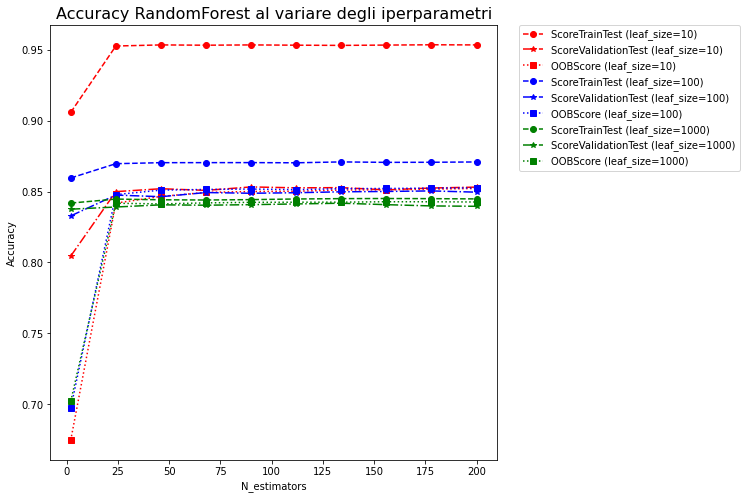

In [ ]:
colors = ['red','blue','green','purple','yellow','brown','orange'] #colori diversi per leaf_size diverse
plt.figure(figsize=(8,8))

for i in range(Nleaf): #ciclo sulle diverse foglie usate
  plt.plot(nEst_range,accTrList[i],marker = 'o',linestyle='dashed',color=colors[i],label=f'ScoreTrainTest (leaf_size={leafSize_range[i]})')
  plt.plot(nEst_range,accValList[i],marker = '*',linestyle='-.',color=colors[i],label=f'ScoreValidationTest (leaf_size={leafSize_range[i]})')
  plt.plot(nEst_range,accOOBList[i],marker='s',linestyle='dotted',color=colors[i],label=f'OOBScore (leaf_size={leafSize_range[i]})')

plt.xlabel('N_estimators')
plt.ylabel('Accuracy')
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Accuracy RandomForest al variare degli iperparametri",fontsize=16)
plt.show()

Per leafSize < 100 vi è un grande stacco fra lo score sul train e quello sul test.
Il Plateau viene raggiunto per Nest $\approx$  100. \\
Scegliamo dunque leafSize=100 e Nest = 100 e facciamo fine tuning qui intorno

In [ ]:
#Range di iperparametri che testo
nEst_range = np.linspace(80,120,10, dtype='int') #n_estimator
leafSize_range = np.array([80,90,100,110,120]) #leaf_size

Nnest = len(nEst_range)
Nleaf = len(leafSize_range)

#liste in cui conservare le accuracy
accOOBList = np.zeros((Nleaf,Nnest))
accTrList = np.zeros((Nleaf,Nnest))
accValList = np.zeros((Nleaf,Nnest))

bestScore = 0 #mi segno i valori migliori che otterrò dai vari modelli
bestLeafSize = nEst_range[0]
bestNest = leafSize_range[0]

print("(leaf_size,n_estimator)      accuracyTrainSet        accuracyValSet       accuracyOOB ")

for i,leaf_size in enumerate(leafSize_range): #ciclo sulla dimensione delle foglie
  #setup del randomforest
  clfRF = RandomForestClassifier(
        n_estimators=nEst_range[0],
        max_depth=None, 
        min_samples_split=leaf_size, 
        oob_score=True,
        random_state=random_state,
        warm_start=True 
    )
  
  for j,n_est in enumerate(nEst_range):

    clfRF.set_params(n_estimators=n_est) #setup random forest

    clfRF.fit(dataTrNorm,labTr) #alleno la random forest

    #calcolo le accuracy
    accTr = clfRF.score(dataTrNorm,labTr)
    accVal = clfRF.score(dataValNorm,labVal)
    accOOB = clfRF.oob_score_

    accTrList[i,j] = accTr
    accValList[i,j] = accVal
    accOOBList[i,j] = accOOB

    print(f"({leaf_size,n_est})                    {np.round(accTr,5)}                 {np.round(accVal,5)}                 {np.round(accOOB,5)}")

    if bestScore <= accOOB : #se l'accuracy aumenta segno il best score
      bestScore =  accOOB
      bestLeafSize = leaf_size
      bestNest = n_est

(leaf_size,n_estimator)      accuracyTrainSet        accuracyValSet       accuracyOOB 
((80, 80))                    0.87455                 0.85033                 0.8507
((80, 84))                    0.87442                 0.84969                 0.85069
((80, 88))                    0.8742                 0.84943                 0.85064
((80, 93))                    0.87428                 0.8502                 0.85097
((80, 97))                    0.87433                 0.84969                 0.85105
((80, 102))                    0.87429                 0.84969                 0.85125
((80, 106))                    0.8746                 0.84905                 0.85105
((80, 111))                    0.87436                 0.84918                 0.85102
((80, 115))                    0.87434                 0.84918                 0.85109
((80, 120))                    0.87436                 0.85007                 0.85101
((90, 80))                    0.87265               

In [ ]:
print("\n\nFinito il fine tuning degli iperparametri risulta:\n")
print(f" -bestScore = {bestScore}\n")
print(f" -bestLeafSize = {bestLeafSize}\n")
print(f" -bestNest = {bestNest}")



Finito il fine tuning degli iperparametri risulta:

 -bestScore = 0.8518997033208919

 -bestLeafSize = 100

 -bestNest = 88


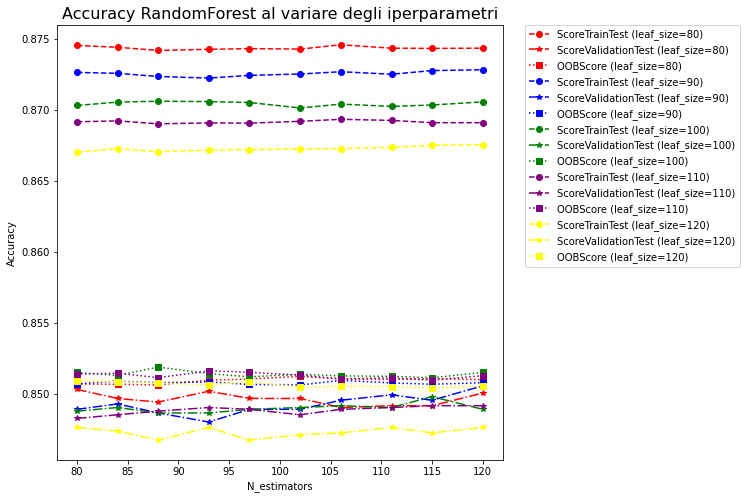

In [ ]:
colors = ['red','blue','green','purple','yellow','brown','orange'] #colori diversi per leaf_size diverse
plt.figure(figsize=(8,8))

for i in range(Nleaf): #ciclo sulle diverse foglie usate
  plt.plot(nEst_range,accTrList[i],marker = 'o',linestyle='dashed',color=colors[i],label=f'ScoreTrainTest (leaf_size={leafSize_range[i]})')
  plt.plot(nEst_range,accValList[i],marker = '*',linestyle='-.',color=colors[i],label=f'ScoreValidationTest (leaf_size={leafSize_range[i]})')
  plt.plot(nEst_range,accOOBList[i],marker='s',linestyle='dotted',color=colors[i],label=f'OOBScore (leaf_size={leafSize_range[i]})')

plt.xlabel('N_estimators')
plt.ylabel('Accuracy')
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Accuracy RandomForest al variare degli iperparametri",fontsize=16)
plt.show()

Utilizziamo ora il miglior modello trovato:

In [ ]:
#implemento ora un random forest con i valori migliori trovati
clfRFBest = RandomForestClassifier(
        n_estimators = bestNest,
        max_depth=None, 
        min_samples_split=bestLeafSize, 
        oob_score=True,
        random_state=0 
    )

clfRFBest.fit(dataTrNorm,labTr) #lo addestro

#calcolo le accuracy
accuracyTr = clfRFBest.score(dataTrNorm,labTr)
accuracyTe = clfRFBest.score(dataTeNorm,labTe)
accuracyOOB = clfRFBest.oob_score_

print(f"OOB Score -> {accuracyOOB}")
print(f"accuracy Train Set -> {accuracyTr}")
print(f"accuracy Test Set -> {accuracyTe}")

accRF = accuracyTe #salvo l'accuracy per ristmparla in segutio

OOB Score -> 0.8518997033208919
accuracy Train Set -> 0.8706255782052509
accuracy Test Set -> 0.8614265662881204


Guardiamo la Confusion Matrix:

In [ ]:
#guardo la confusion Matrix
labPred = clfRFBest.predict(dataTeNorm) #label di classe predette dal modello

confusion_matrix(labPred,labTe,normalize='true')

array([[0.84010708, 0.15989292],
       [0.11507511, 0.88492489]])

Calcolo dell'AUC score

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(labTe, labPred) #label del Test set e previsioni calcolate nella cella sopra
auc = metrics.auc(fpr, tpr) #calcolo l'auc

print(f"AUC = {auc}")

aucRF = auc #salvo l'auc per ristamparla in seguito

AUC = 0.8616923168509882


Usiamo il miglior modello Random Forest trovato per trovare ora il ranking delle feature per importanza:

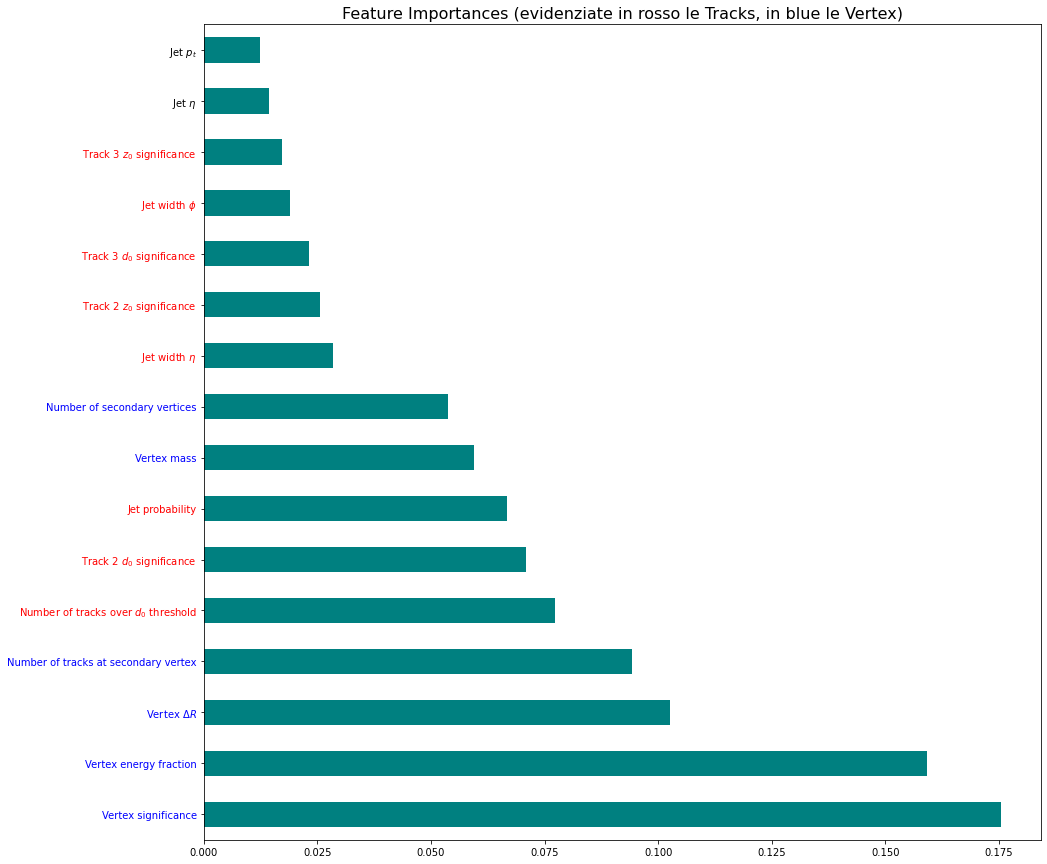

In [ ]:
importances = clfRFBest.feature_importances_ #vedo la lista dell'importanza delle feature

#ordino la lista per poterci fare un plot:

orderedIndex = np.argsort(importances)[::-1] #indici dal maggiore al minore 
orderedColumns = [ feat_plot[ orderedIndex[i] ] for i in range(len(feat_plot)) ] #nomi delle colonne ordinate
orderedImportances = [ importances[ orderedIndex[i] ] for i in range(len(importances)) ]

myColors = ['black','black'] +  ['red'] * len(trackNames) + ['blue'] * len(vertexNames) #coloi che voglio sul grafico
orderedColors = [ myColors[ orderedIndex[i] ] for i in range(len(myColors)) ]

#plot:

plt.figure(figsize=(15,15))
feat_importances = pd.Series(orderedImportances,orderedColumns)
feat_importances.plot(kind='barh',color='teal')

#coloro in rosso le track feature e in blue le vertex feature
for i in range(len(feat)):
  plt.gca().get_yticklabels()[i].set_color(orderedColors[i])

plt.title("Feature Importances (evidenziate in rosso le Tracks, in blue le Vertex)", fontsize=16)

plt.show()

## 3) Recurrent Neural Network

Prima di eseguire le celle succesive modificare la batch_size a seconda del numero di righe lette dal dataset. \\
Modificare sequence_lenght per cambiare il numero di eventi con cui viene predetta la label. \\
Modificare epochs per cambiare la durata del loop di training.

In [ ]:
batch_size = 256       #dimensione del batch   
sequence_length = 80  #lunghezza della sequenza di eventi con cui si fanno predizioni
epochs = 50

### Creazione del Dataset per la RNN e definizione del modello

Per prima cosa creiamo un dataset in cui gli eventi sono ordinati in base alle feature più importanti (per questo è necessario aver prima eseguito la random Forest)

Dato che si è notato che prendendo il test set come l'ultima parte del dataset ordinato si aveva una popolazione delle label sbilanciate in fase di test, prima si opera la divisione in train-validation-test e poi si ordinano i dataset

In [ ]:
dfRNN = pd.read_pickle(newFileName) #dataframe a cui voglio aggiungere la colonna label

#creo un array con le label come fatto in precedenza per ogni array
labelRNN = np.zeros(len(dfRNN),dtype=int)
labelRNN[np.where(dfRNN["flavor"]==5)] = 1   
dfRNN['Label'] = labelRNN #aggiungo le label al df
dfRNN = dfRNN.drop(["flavor"], axis = 1) #elimino la colonna flavour

#divido il campione in Tr-Val-Te e lo ordino per la LSTM

#separo i campioni prima e poi li ordino separatamente per non rischiare di avere dataset sbilanciati

#splitto dataset e label 80% train 10% val 10% test
dfTr, dfSplit = train_test_split(dfRNN,train_size = trainRatio, shuffle = True, random_state = random_state)
dfVal, dfTe = train_test_split(dfSplit,train_size = valtestRatio, shuffle = True, random_state = random_state)

#feature ordinate per importanza rispetto alle quali ordino gli array
orderedFeat = [ feat[ orderedIndex[i] ] for i in range(len(feat)) ]

dfTrainSort = dfTr.sort_values(by=orderedFeat, ascending=False)
dfValSort = dfVal.sort_values(by=orderedFeat, ascending=False)
dfTestSort = dfTe.sort_values(by=orderedFeat, ascending=False)

#check sul lavoro fatto
print("\nTrain Set Ordinato\n")
display(dfTrainSort.head())
print("\nValidation Set Ordinato\n")
display(dfValSort.head())
print("\nTest Set Ordinato\n")
display(dfTestSort.head())


print("\n\nTrain set fraction:", len(dfTrainSort) / len(dfRNN))
print("Val set fraction:", len(dfValSort) / len(dfRNN))
print("Test set fraction:", len(dfTestSort) / len(dfRNN))



Train Set Ordinato



,jet_pt,jet_eta,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction,Label
15935,58.4074,2.261310,1.298150,0.556685,1.244040,0.412401,1,7.256780e-03,0.077882,0.111906,2434.03,1,2,5.429880,0.689292,0.633075,0
54313,37.0265,-1.783670,5.899330,6.341700,37.269000,57.379300,3,4.719920e-09,0.150979,0.045746,2323.05,1,2,0.280990,0.895249,0.199815,1
35643,26.1319,-1.606140,0.927808,0.337975,0.712069,1.611460,0,5.821440e-02,0.150068,0.182787,2238.55,1,2,0.076561,0.498211,0.161373,0
1379,36.1446,0.676253,4.604050,1.681800,1.234000,1.556920,2,2.388500e-07,0.123551,0.103328,2130.93,1,2,3.434590,0.300134,0.245729,0
56834,30.1184,0.629782,25.082400,2.113400,12.047800,0.658565,3,1.192390e-09,0.075967,0.078424,2034.15,1,2,3.331120,0.333515,0.142741,1



Validation Set Ordinato



,jet_pt,jet_eta,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction,Label
41824,31.6710,-2.366390,29.30400,-1.00000,1.167720,-1.000000,2,6.687210e-11,0.074488,0.103494,1272.890,1,2,0.115722,0.985224,0.451727,1
69001,26.6572,1.906370,9.46953,4.03319,188.379000,17.380300,5,6.581950e-09,0.161884,0.112848,962.417,3,7,0.118064,1.736600,0.891238,1
61490,28.5080,-1.432960,45.44270,39.05470,2.788200,49.924000,7,8.130100e-28,0.079040,0.082597,951.265,5,13,0.081733,4.412140,0.937693,1
52372,33.1938,-2.295320,102.19200,1.54626,44.084200,7.926980,2,1.958040e-21,0.046189,0.066398,947.450,1,2,0.148860,0.406602,0.101175,1
15678,72.7825,0.385594,1.46341,1.65763,0.008031,0.735274,1,1.007340e-03,0.069197,0.115336,914.370,1,2,0.083553,0.477962,0.227180,0



Test Set Ordinato



,jet_pt,jet_eta,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction,Label
60400,26.9182,-0.87516,9.52765,0.100344,3.54496,1.554290,2,8.314260e-07,0.105272,0.201174,1989.18,1,2,0.214277,0.546666,0.313358,1
70216,23.2826,2.28840,1.76899,1.443370,7.36107,0.806342,1,1.499890e-04,0.120189,0.113176,1697.28,1,2,0.166324,1.030510,0.402110,1
68498,50.5567,-1.78352,36.72610,28.565900,40.84050,39.511300,6,1.245260e-21,0.068594,0.118186,1613.35,3,6,0.167929,2.001160,0.464111,1
3591,39.0557,1.22258,18.14570,9.025870,11.42830,7.294880,3,3.895540e-09,0.093487,0.114963,1436.36,1,2,0.355348,0.751211,0.118472,0
72957,39.9681,2.03542,14.58420,2.137910,31.69120,0.212281,3,7.526990e-09,0.150936,0.083342,1289.56,2,4,0.076017,1.797960,0.766463,1




Train set fraction: 0.7999948958758677
Val set fraction: 0.10000255206206615
Test set fraction: 0.10000255206206615


In [ ]:
#normalizzazione delle feature

print("\nStatistica descrittiva di Test-Val-Train prima della normalizzazione\n")
display(dfTrainSort.describe())
display(dfValSort.describe())
display(dfTestSort.describe())

#ciclo sulle colonne e normalizzo al training set
for col in feat:
  mean = dfTrainSort[col].mean() #usiamo solo i dati di training per ricavare media e stdev
  stdev = dfTrainSort[col].std()
  dfTrainSort[col] = (dfTrainSort[col] - mean) / stdev
  dfValSort[col] = (dfValSort[col] - mean) / stdev
  dfTestSort[col] = (dfTestSort[col] - mean) / stdev

print("\nStatistica descrittiva di Test-Val-Train dopo la normalizzazione\n")
display(dfTrainSort.describe())
display(dfValSort.describe())
display(dfTestSort.describe())


Statistica descrittiva di Test-Val-Train prima della normalizzazione



,jet_pt,jet_eta,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction,Label
count,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000,62694.000000
mean,33.957743,-0.001663,4.245643,2.084537,3.771127,2.019731,1.524149,0.032499,0.086596,0.095698,44.990958,0.074250,1.319313,-0.382521,0.208917,-0.224876,0.498405
std,12.586468,1.356730,7.512519,4.941995,16.950842,10.164956,1.700986,0.097607,0.087211,0.089362,97.473717,1.309878,3.373545,0.929767,1.670931,0.927533,0.500001
min,22.955800,-2.499590,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,26.308900,-1.127505,0.629733,0.083672,0.368271,0.064344,0.000000,0.000006,0.057097,0.064534,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,30.175150,-0.011581,1.337165,0.693550,0.947823,0.645545,1.000000,0.003561,0.085338,0.094554,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,37.008800,1.126940,4.509190,1.888278,2.123900,1.557435,3.000000,0.040878,0.118682,0.129292,53.221075,1.000000,3.000000,0.097959,1.126185,0.652752,1.000000
max,268.903000,2.499910,127.504000,117.329000,867.027000,1073.240000,12.000000,0.414309,0.399856,0.397828,2434.030000,6.000000,35.000000,6.406020,16.540100,3.610980,1.000000


,jet_pt,jet_eta,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction,Label
count,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000
mean,34.023010,-0.018108,4.346040,2.088705,3.513790,1.995400,1.545489,0.031795,0.087008,0.095880,45.785487,0.105397,1.391987,-0.372408,0.251984,-0.203862,0.507975
std,12.481554,1.352625,7.775407,4.695298,12.030999,7.079110,1.707303,0.097508,0.087594,0.089330,93.226133,1.320749,3.394509,0.934157,1.697638,0.933779,0.499968
min,22.957700,-2.498990,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,26.370100,-1.147560,0.640080,0.092451,0.361877,0.071939,0.000000,0.000004,0.057316,0.065595,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,30.311500,-0.047384,1.365400,0.723974,0.953759,0.678990,1.000000,0.003357,0.086224,0.094785,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
75%,37.213400,1.086850,4.907590,1.948030,2.169050,1.578310,3.000000,0.039470,0.118830,0.129199,55.509900,1.000000,3.000000,0.097171,1.180410,0.681698,1.000000
max,212.552000,2.499190,149.124000,53.397000,369.552000,303.622000,10.000000,0.397201,0.367381,0.393368,1272.890000,5.000000,26.000000,5.722040,11.668300,2.989450,1.000000


,jet_pt,jet_eta,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction,Label
count,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000
mean,34.125188,-0.006527,4.408069,2.130491,3.743558,1.946991,1.556080,0.033229,0.087360,0.096345,47.027592,0.108970,1.405768,-0.374814,0.251909,-0.206710,0.504785
std,13.593394,1.339869,7.967750,4.972070,15.331276,7.812716,1.729492,0.096042,0.083934,0.086285,102.857523,1.326245,3.464316,0.913478,1.703579,0.929288,0.500009
min,22.948600,-2.498400,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,26.381400,-1.116670,0.626345,0.090345,0.356412,0.070526,0.000000,0.000005,0.057347,0.065128,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,30.126600,-0.015641,1.354830,0.700541,0.952505,0.645257,1.000000,0.003293,0.086003,0.093843,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
75%,36.817500,1.088330,4.631390,1.985060,2.130220,1.552550,3.000000,0.040408,0.119490,0.129348,55.596100,1.000000,3.000000,0.101804,1.174320,0.663751,1.000000
max,356.424000,2.499630,94.883600,64.218100,531.841000,334.844000,11.000000,0.409195,0.381938,0.378135,1989.180000,6.000000,38.000000,5.663520,11.173400,3.439930,1.000000



Statistica descrittiva di Test-Val-Train dopo la normalizzazione



,jet_pt,jet_eta,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction,Label
count,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,6.269400e+04,62694.000000
mean,-2.030964e-16,2.402703e-17,4.352066e-17,3.626721e-17,-2.176033e-17,2.901377e-17,-1.015482e-16,1.450689e-17,5.077410e-17,1.305620e-16,-1.305620e-16,-1.740826e-16,1.305620e-16,-5.077410e-17,-1.378154e-16,-1.740826e-16,0.498405
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.500001
min,-8.741089e-01,-1.841137e+00,-6.982535e-01,-6.241482e-01,-2.814684e-01,-2.970727e-01,-8.960387e-01,-1.057813e+01,-1.245934e+01,-1.226134e+01,-4.718293e-01,-8.201144e-01,-6.875003e-01,-6.641219e-01,-7.234987e-01,-8.356834e-01,0.000000
25%,-6.077037e-01,-8.298199e-01,-4.813178e-01,-4.048701e-01,-2.007485e-01,-1.923656e-01,-8.960387e-01,-3.329010e-01,-3.382478e-01,-3.487415e-01,-4.718293e-01,-8.201144e-01,-6.875003e-01,-6.641219e-01,-7.234987e-01,-8.356834e-01,0.000000
50%,-3.005286e-01,-7.310028e-03,-3.871508e-01,-2.814626e-01,-1.665583e-01,-1.351886e-01,-3.081443e-01,-2.964806e-01,-1.442377e-02,-1.280444e-02,-4.718293e-01,-8.201144e-01,-6.875003e-01,-6.641219e-01,-7.234987e-01,-8.356834e-01,0.000000
75%,2.424077e-01,8.318550e-01,3.508110e-02,-3.971266e-02,-9.717670e-02,-4.547943e-02,8.676445e-01,8.584698e-02,3.679058e-01,3.759220e-01,8.443422e-02,7.067457e-01,4.981962e-01,5.167741e-01,5.489564e-01,9.461968e-01,1.000000
max,1.866650e+01,1.843825e+00,1.640706e+01,2.331942e+01,5.092702e+01,1.053837e+02,6.158694e+00,3.911707e+00,3.591956e+00,3.380961e+00,2.450957e+01,4.523896e+00,9.983768e+00,7.301332e+00,9.773702e+00,4.135549e+00,1.000000


,jet_pt,jet_eta,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction,Label
count,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000
mean,0.005185,-0.012121,0.013364,0.000843,-0.015181,-0.002394,0.012546,-0.007209,0.004715,0.002030,0.008151,0.023779,0.021542,0.010877,0.025775,0.022656,0.507975
std,0.991665,0.996974,1.034993,0.950081,0.709758,0.696423,1.003714,0.998983,1.004390,0.999640,0.956423,1.008299,1.006214,1.004721,1.015983,1.006735,0.499968
min,-0.873958,-1.840695,-0.698253,-0.624148,-0.281468,-0.297073,-0.896039,-10.578130,-12.459337,-12.261336,-0.471829,-0.820114,-0.687500,-0.664122,-0.723499,-0.835683,0.000000
25%,-0.602841,-0.844602,-0.479941,-0.403094,-0.201126,-0.191618,-0.896039,-0.332918,-0.335742,-0.336871,-0.471829,-0.820114,-0.687500,-0.664122,-0.723499,-0.835683,0.000000
50%,-0.289696,-0.033700,-0.383392,-0.275306,-0.166208,-0.131898,-0.308144,-0.298568,-0.004275,-0.010222,-0.471829,-0.820114,-0.687500,-0.664122,-0.723499,-0.835683,1.000000
75%,0.258663,0.802306,0.088113,-0.027622,-0.094513,-0.043426,0.867645,0.071419,0.369603,0.374887,0.107916,0.706746,0.498196,0.515927,0.581408,0.977404,1.000000
max,14.189386,1.843294,19.284923,10.382945,21.578920,29.670789,4.982905,3.736432,3.219585,3.331052,12.597232,3.760466,7.315951,6.565686,6.858082,3.465459,1.000000


,jet_pt,jet_eta,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction,Label
count,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000,7837.000000
mean,0.013304,-0.003585,0.021621,0.009299,-0.001626,-0.007156,0.018772,0.007475,0.008754,0.007237,0.020894,0.026507,0.025627,0.008290,0.025729,0.019586,0.504785
std,1.080001,0.987572,1.060596,1.006086,0.904455,0.768593,1.016759,0.983964,0.962416,0.965561,1.055233,1.012495,1.026907,0.982480,1.019539,1.001893,0.500009
min,-0.874681,-1.840260,-0.698253,-0.624148,-0.281468,-0.297073,-0.896039,-10.578130,-12.459337,-12.261336,-0.471829,-0.820114,-0.687500,-0.664122,-0.723499,-0.835683,0.000000
25%,-0.601944,-0.821834,-0.481769,-0.403520,-0.201448,-0.191757,-0.896039,-0.332911,-0.335379,-0.342091,-0.471829,-0.820114,-0.687500,-0.664122,-0.723499,-0.835683,0.000000
50%,-0.304386,-0.010303,-0.384799,-0.280048,-0.166282,-0.135217,-0.308144,-0.299226,-0.006803,-0.020762,-0.471829,-0.820114,-0.687500,-0.664122,-0.723499,-0.835683,1.000000
75%,0.227209,0.803397,0.051347,-0.020129,-0.096804,-0.045960,0.867645,0.081027,0.377171,0.376554,0.108800,0.706746,0.498196,0.520910,0.577764,0.958055,1.000000
max,25.620075,1.843618,12.064922,12.572567,31.153017,32.742322,5.570800,3.859313,3.386501,3.160588,19.945777,4.523896,10.873041,6.502746,6.561900,3.951135,1.000000


Dato che non ci interessa fare previsioni nel futuro per predire il target di un evento usiamo le feature di quell'evento e di tutti quelli prima

In [ ]:
target='Label' #ciò che ci interessa predire è la label dell'evento stesso, non label successive

In [ ]:
# test funzionamento  della classe SequenceDataset con cui si implementa il dataset per la RNN

i = 24 #numero casuale
seqLen = 5 #lunghezza della sequenza con cui si predice la label

prova_dataset = SequenceDataset(
    dfTrainSort,
    target=target,
    features=feat,
    sequence_length=seqLen
)

x, y = prova_dataset[i]
print("Prova Dataset:")
print(f"x:\n{x}")
print(f"y:\n{y}")

Prova Dataset:
x:
tensor([[ 6.2674e-01,  1.5070e+00,  6.3044e+00,  1.0724e+01,  6.6085e+00,
          1.1152e+00,  2.0434e+00, -3.3296e-01,  2.0440e-01, -5.8552e-03,
          1.1857e+01,  1.4702e+00,  1.0910e+00,  4.7885e-01,  1.1670e+00,
          1.4180e+00],
        [-8.0982e-01,  1.2273e+00, -1.2968e-01, -1.4234e-01, -1.7712e-01,
         -1.5424e-01,  2.7975e-01, -3.3296e-01,  3.0272e-01, -1.0053e-01,
          1.1807e+01,  1.4702e+00,  7.9462e-01,  5.7645e-01,  6.6021e-01,
          9.2242e-01],
        [-1.4813e-02, -1.5983e+00, -5.4274e-01, -6.2415e-01, -1.5374e-01,
         -2.9707e-01, -3.0814e-01, -3.3258e-01,  5.1333e-01, -3.5478e-02,
          1.1693e+01,  7.0675e-01,  2.0177e-01,  4.8597e-01,  8.0527e-01,
          1.2192e+00],
        [-8.0737e-01, -1.6242e+00, -4.0698e-01, -2.1387e-01, -2.0093e-01,
         -1.6938e-01, -3.0814e-01, -2.8819e-01,  3.6148e-01, -1.2652e-01,
          1.1666e+01,  7.0675e-01,  2.0177e-01,  5.6629e-01,  2.4872e-01,
          4.8811e-01],
  

In [ ]:
# Creiamo i dataset di train,validation e test

#batch_size: definita nella prima cella della RNN
#sequence_length: definita nella prima cella della RNN

train_dataset = SequenceDataset(
    dfTrainSort,
    target=target,
    features=feat,
    sequence_length=sequence_length
)
val_dataset = SequenceDataset(
    dfValSort,
    target=target,
    features=feat,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    dfTestSort,
    target=target,
    features=feat,
    sequence_length=sequence_length
)


TrLoaderRNN = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
ValLoaderRNN = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
TeLoaderRNN = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

x, y = next(iter(TrLoaderRNN))

print("\nCheck sul DataLoader:")
print("Features shape:", x.shape)
print("Target shape:", y.shape)
print(f"x:\n{x}")
print(f"y:\n{y}")


Check sul DataLoader:
Features shape: torch.Size([256, 80, 16])
Target shape: torch.Size([256])
x:
tensor([[[-0.5040,  0.8504, -0.5161,  ..., -0.6641, -0.7235, -0.8357],
         [-0.6437,  1.0633, -0.5161,  ..., -0.6641, -0.7235, -0.8357],
         [ 0.4479,  0.3100, -0.5161,  ..., -0.6641, -0.7235, -0.8357],
         ...,
         [ 0.5429,  0.7353, -0.5168,  ..., -0.6641, -0.7235, -0.8357],
         [ 1.4981, -0.7663, -0.5168,  ..., -0.6641, -0.7235, -0.8357],
         [-0.6572, -0.6773, -0.5168,  ..., -0.6641, -0.7235, -0.8357]],

        [[ 0.3411,  0.9528,  0.2119,  ...,  0.5594,  0.9741,  0.9949],
         [-0.2657, -1.5962,  0.9069,  ...,  0.5886,  0.7815,  1.0542],
         [-0.6350,  1.2717, -0.2326,  ...,  0.4486,  0.0925,  1.1697],
         ...,
         [ 0.5478,  1.7299, -0.0321,  ...,  0.5873,  1.7817,  0.9427],
         [ 0.8307,  1.1871, -0.4323,  ...,  0.4953,  0.3855,  0.8319],
         [-0.6797,  0.2169,  0.2227,  ...,  0.4399,  0.4132,  0.5803]],

        [[-0.333

### Definizione del modello

Definiamo ora la RNN

In [ ]:
# LSTM model

class myLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.input_dim = input_dim  # numero di features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers #usiamo una LSTM o una stack LSTM a seconda dell'input
        self.dropout = dropout

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True, # necessario se l'input ha shape (batch, seq. len., features) altrimenti (seq.len., batch, features)
            num_layers=self.num_layers,
            dropout = self.dropout #dropout che passiamo come input
        )

        # uscita un layer denso con 2 neuroni di uscita (perché ci sono due classi)
        self.linear = nn.Linear(in_features=self.hidden_dim, out_features=2)

    def forward(self, x):
        batch_size = x.shape[0]
        # inzializziamo a zero hidden state e cell state 
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device).requires_grad_() 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device).requires_grad_()


        
        # ci interessa solo l'hidden state, quindi non consideriamo il cell state e l'output
        on, (hn, cn) = self.lstm(x, (h0, c0))

        #gli stiamo passando solo hidden state

        out = F.log_softmax( self.linear(hn[0]) , dim=1) # la prima dimensione di h è il numero di layers che è pari a 1
        return out

In [ ]:
# definiamo loss e optimizer

learning_rate = 5e-4
num_hidden_units = 64
num_layers = 2 #-> per una stack LSTM
dropout = 0.3

model3 = myLSTM(input_dim=len(feat), hidden_dim=num_hidden_units, num_layers=num_layers, dropout=dropout)

print(model3)

#(TorchSummary non funziona con LSTM)

#loss:
loss_func = nn.CrossEntropyLoss() #(è una classificazione)

#optimizer:
opt3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

#metrica:
metric_func = accuracy

myLSTM(
  (lstm): LSTM(16, 64, num_layers=2, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
# testiamo il modello su un batch 
xb, yb = next(iter(TrLoaderRNN))
out = model3(xb)

print("Test su un batch")
print(f"out shape: {out.shape}")
print(f"out:\n{out}") #ogni elemento del vettore è la predizione per ogni elemento del batch

Test su un batch
out shape: torch.Size([256, 2])
out:
tensor([[-0.7258, -0.6615],
        [-0.7056, -0.6809],
        [-0.6689, -0.7180],
        [-0.6681, -0.7188],
        [-0.7022, -0.6842],
        [-0.6705, -0.7163],
        [-0.6110, -0.7826],
        [-0.7138, -0.6729],
        [-0.7039, -0.6825],
        [-0.6926, -0.6937],
        [-0.6571, -0.7305],
        [-0.6842, -0.7022],
        [-0.6858, -0.7006],
        [-0.7151, -0.6717],
        [-0.7187, -0.6682],
        [-0.6944, -0.6919],
        [-0.7091, -0.6774],
        [-0.6509, -0.7373],
        [-0.7106, -0.6760],
        [-0.7096, -0.6769],
        [-0.6030, -0.7923],
        [-0.6242, -0.7672],
        [-0.6927, -0.6936],
        [-0.6624, -0.7248],
        [-0.6749, -0.7117],
        [-0.6640, -0.7232],
        [-0.6369, -0.7527],
        [-0.7172, -0.6697],
        [-0.7663, -0.6250],
        [-0.6658, -0.7212],
        [-0.6677, -0.7192],
        [-0.6740, -0.7127],
        [-0.6889, -0.6974],
        [-0.7273, -0.6

### Training RNN

In [ ]:
#Training loop

model3.to(device) #->per l'LSTM non serve mandarlo sulla gpu
save_best_model3 = SaveBestModel(name='best_modelloRNN.pt') #-> inizializzo la funzione per salvarmi il bestModel

# numero di epoche definito nella prima cella della RNN

# liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione 
# dell'epoca a fine addestramento
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

# loop sulle epoche
for epoch in range(epochs):
    t0 = time.time()
    
    # training step (in cui aggiorniamo i pesi della rete neurale)
    model3.train()
    train_loss = 0
    train_metric = 0
    counter = 0

    for xb, yb in TrLoaderRNN:
        counter += 1
        xb=xb.to(device) #copio il mini batch di dati sulla CPU/GPU
        yb=yb.to(device) #copio il mini batch di label sulla CPU/GPU

        pred = model3(xb) #predizione del modello

        # calcolo loss e metrica
        loss = loss_func(pred.squeeze(), yb)
        metric = metric_func(pred.squeeze(), yb)

        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        train_metric += metric.item()

        # backpropagation
        opt3.zero_grad() #resetta i gradienti prima di eseguire la backpropagation
        loss.backward() #calcola i gradeinti della loss
        opt3.step() #aggiorna i pesi


    train_loss /= counter
    train_metric /= (counter*batch_size)
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # validation step (non vengono aggiornati i pesi)
    model3.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad(): #evita che si aggiornino i pesi
      for xb, yb in ValLoaderRNN:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = model3(xb) #predizione del modello

        # calcolo loss e metrica
        vloss = loss_func(pred.squeeze(), yb)
        vmetric = metric_func(pred.squeeze(), yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()  

    vali_loss /= counter
    vali_metric /= (counter*batch_size)
    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model3(vali_loss, epoch, model3, opt3, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train Accuracy: %.6f, vali loss: %.6f, vali Accuracy: %.6f" 
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))


Best validation loss: 0.39911722441514336

Saving best model for epoch: 1

epoch: 1, time(s): 2.7596, train loss: 0.435840, train Accuracy: 0.816678, vali loss: 0.399117, vali Accuracy: 0.829427

Best validation loss: 0.3834196855624517

Saving best model for epoch: 2

epoch: 2, time(s): 2.7526, train loss: 0.389899, train Accuracy: 0.831615, vali loss: 0.383420, vali Accuracy: 0.833203

Best validation loss: 0.3804212739070257

Saving best model for epoch: 3

epoch: 3, time(s): 2.8187, train loss: 0.379745, train Accuracy: 0.835537, vali loss: 0.380421, vali Accuracy: 0.832292

Best validation loss: 0.3778954992691676

Saving best model for epoch: 4

epoch: 4, time(s): 2.7398, train loss: 0.376924, train Accuracy: 0.835841, vali loss: 0.377895, vali Accuracy: 0.832943

Best validation loss: 0.3755622843901316

Saving best model for epoch: 5

epoch: 5, time(s): 3.7027, train loss: 0.376049, train Accuracy: 0.836258, vali loss: 0.375562, vali Accuracy: 0.834375
epoch: 6, time(s): 2.724

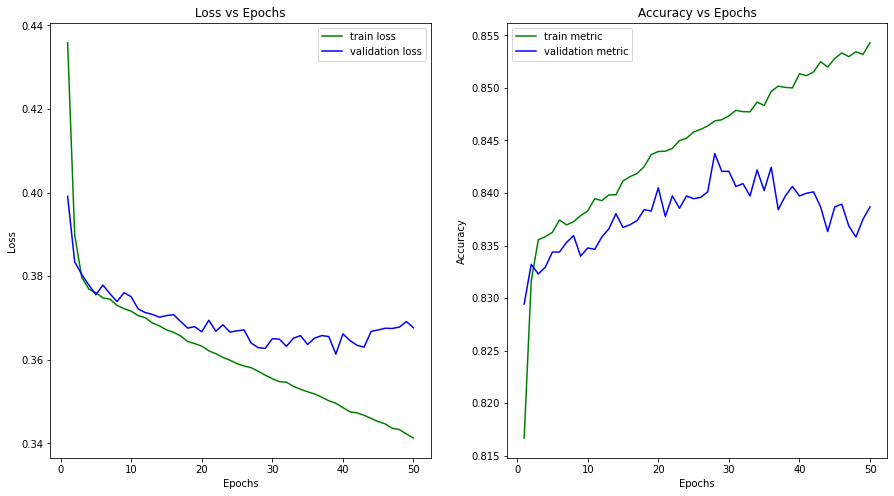

In [ ]:
# grafico monitoring training

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1), hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs Epochs")
plt.legend()

In [ ]:
# test set performance

# lettura del modello
model_data = torch.load('./best_modelloRNN.pt')  #il best model è quello che ha dato la migliore prestazione
print('Best model at epoch: ', model_data['epoch']) #l'epoca a cui ho raggiunto il best model
model = model_data['model'] 
model.eval() 

# Per l'inferenza uso la cpu
model.to(torch.device('cpu'))

loss = 0
metric = 0
counter = 0

for xb, yb in TeLoaderRNN:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb)

  loss += loss_func(pred, yb).item()
  metric += metric_func(pred, yb).item()


loss /= counter
metric /= (counter*batch_size)

print('Test loss/accuracy: ',loss, ' / ', metric)

accRNN = metric #salvo l'accuracy per ristamparla in seguito

Best model at epoch:  39
Test loss/accuracy:  0.356302402416865  /  0.851171875


In [ ]:
#mi stampo la confusion matrix

model.to(torch.device('cpu')) #mi sposto sulla cpu

predictions = np.empty(shape=(0,))
truths = np.empty(shape=(0,))
 
for xb, yb in TeLoaderRNN:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  outputs = model(xb)

  res = torch.argmax(outputs.data,1)

  predictions = np.concatenate((predictions,res.detach().numpy()))
  truths = np.concatenate((truths,yb.detach().numpy()))

c_mat = confusion_matrix(predictions, truths, normalize='true')
print('Matrice di correlazione: ')
print(c_mat)

Matrice di correlazione: 
[[0.82742606 0.17257394]
 [0.11869602 0.88130398]]


In [ ]:
auc = []
for xb, yb in TeLoaderRNN:
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  outputs = model(xb)
  pred = torch.argmax(outputs.data,1)

  fpr, tpr, thresholds = metrics.roc_curve(yb.detach().numpy(), pred)
  auc.append(metrics.auc(fpr, tpr))

print(f"AUC = {round(np.mean(auc),4)} +- {round(np.std(auc),4)}")

aucRNN = np.mean(auc) #salvo l'auc per ristamparla in seguito

AUC = 0.8517 +- 0.0248


# Riepilogo Score ottenuti: 



In [ ]:
print("Score Ottenuti:\n\n")
print(f"Rete Densa:\n -Accuracy {round(accDense,4)}\n -AUC      {round(aucDense,4)}\n")
print(f"RandomForest:\n -Accuracy {round(accRF,4)}\n -AUC      {round(aucRF,4)}\n")
print(f"RNN:\n -Accuracy {round(accRNN,4)}\n -AUC      {round(aucRNN,4)}\n")

Score Ottenuti:


Rete Densa:
 -Accuracy 0.8546
 -AUC      0.8547

RandomForest:
 -Accuracy 0.8614
 -AUC      0.8617

RNN:
 -Accuracy 0.8512
 -AUC      0.8517



Modello                          | Accuracy | AUC   
---------------------------------|----------|-------------
Rete Densa                       | 85.5%    | 85.5% 
Random Forest                    | 86.1%    | 86.2%
RNN                              | 85.1%    | 85.2%